In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time 
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
def get_loss(pred, actual):
  loss = mean_squared_error(pred, actual)
  result = np.sqrt(loss)
  return result

In [0]:
def kfold_validate(X, y, te, model, col):
    scores = np.zeros(k)
    for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
        X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
        X_val, y_val = X.iloc[val_idx, :], y[val_idx]

        model.fit(X_tr, y_tr)
        pred_val = model.predict(X_val)
        scores[i] = get_loss(pred_val, y_val)
        print("========={}-th Fold Score: {}".format(i, scores[i]))
        
        meta_tr[col][val_idx] = pred_val
        meta_tr['val'][val_idx] = y_val

    print("=========Total Score: ", np.mean(scores))
    model.fit(X, y)
    meta_te[col] = model.predict(te)

## Load the data

In [7]:
# Import the all dataset
tr = pd.read_csv('train_3.csv')
te = pd.read_csv('test_3.csv')

# Final check
print("The size of the train set ", tr.shape)    # (3000, 377)
print("The size of the test set ", te.shape)

The size of the train set  (3000, 377)
The size of the test set  (4398, 376)


In [8]:
print("=======NAs in train set\n", tr.isnull().sum()[tr.isnull().sum() != 0])
print("=======NAs in test set\n", te.isnull().sum()[te.isnull().sum() != 0])

=======NAs in train set
 n_crew_profile    16
dtype: int64
=======NAs in test set
 n_crew_profile         22
r_rating_totalVotes     1
dtype: int64


In [0]:
tr.fillna(-1, inplace = True)
te.fillna(-1, inplace = True)

In [10]:
te.iloc[:, :45].describe()

,budget_log,popularity_log,runtime_h,runtime_log,runtime_m,status,is_collection,is_homepage,n_genres,n_prod_count,n_prod_comp,n_spoken_lang,cast_male,crew_male,n_crew_profile,year,month,day,weekofday,rating,n_cast_log,n_crew_log,popularity2_log,totalVotes_log,popularity_diff_log,r_runtime_rating,r_rating_totalVotes,r_budget_rating,r_popularity_totalVotes,r_popularity_rating,r_popularity_ngenres,r_popularity_n_cast,r_budget_totalVotes,r_budget_runtime,r_budget_year,r_totalVotes_year,r_rating_year,r_rating_year2,m_rating_totalVotes,m_year_popularity,m_year_budget,m_year_totalVotes_log,m_year_rating,m_year_runtime,m_year_n_crew_log
count,4398.000000,4.398000e+03,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4.398000e+03,4398.000000,4398.000000,4.398000e+03,4.398000e+03,4.398000e+03,4.398000e+03,4.398000e+03,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4.398000e+03,4398.000000,4398.000000,4398.000000,4398.000000
mean,11.799167,1.985449e+00,1.225330,4.659979,0.015688,1.000227,0.199409,0.322874,2.497726,1.364484,2.922237,1.451342,0.233584,0.088549,0.290208,1999.675534,6.889723,15.379036,3.228286,6.114461,2.864404,2.743025,2.012873,5.412860,0.292240,-0.015062,0.096662,4.187490e+06,3.427411,0.524288,3.934207e+00,5.190416e-01,1.069355e+05,2.040717e+05,2.725831e+05,0.073227,0.003058,0.086140,5.410260,1.981314,2.257493e+07,5.409854,6.114776,0.000765,20.975950
std,7.444733,7.509477e-01,0.452848,0.309302,0.998423,0.058407,0.399601,0.467628,1.111836,0.792381,2.250990,0.888750,0.149346,0.119434,0.254200,15.286707,3.370176,8.571856,1.341997,1.544581,0.688653,0.995944,0.611603,1.946927,0.248682,1.811774,0.350092,2.896592e+07,1.378183,1.461456,4.480953e+00,1.490366e+00,1.455504e+06,3.287007e+05,4.622628e+05,0.057485,0.000776,0.092460,1.135203,0.176196,9.773718e+06,0.479200,0.295658,0.127683,3.764882
min,0.000000,9.999995e-07,-0.000000,0.000000,-2.177292,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,1922.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.470004,0.000000,0.000287,-21.772921,-1.000000,0.000000e+00,-2.072503,0.000010,5.000000e-07,1.666667e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.690821,0.191453,3.000000e+02,1.791759,5.500000,-1.854838,8.000000
25%,0.000000,1.588252e+00,1.000000,4.553877,-0.548900,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.125000,0.000000,0.120000,1992.000000,4.000000,8.000000,2.000000,5.700000,2.484907,2.197225,1.676208,4.158883,0.109869,-0.091133,0.005544,0.000000e+00,2.556456,0.263012,1.647093e+00,2.015742e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.052699,0.002850,0.066667,5.381652,1.911811,1.324143e+07,5.112093,5.942373,-0.048236,19.090909
50%,15.816991,2.137975e+00,1.000000,4.653960,0.144376,1.000000,0.000000,0.000000,2.000000,1.000000,2.000000,1.000000,0.214286,0.058824,0.240000,2004.000000,7.000000,15.000000,4.000000,6.400000,2.833213,2.708050,2.117700,5.549076,0.238206,0.024892,0.019939,1.142857e+06,3.392426,0.333746,3.007754e+00,3.679115e-01,1.748362e+04,6.796117e+04,1.011236e+05,0.069521,0.003182,0.076220,5.602962,1.953762,2.664833e+07,5.489345,6.060645,0.001543,20.035370
75%,17.147715,2.479770e+00,1.000000,4.779123,0.724793,1.000000,0.000000,1.000000,3.000000,1.000000,4.000000,2.000000,0.333333,0.130435,0.400000,2011.000000,10.000000,23.000000,4.000000,7.000000,3.218876,3.367296,2.408745,6.806829,0.410693,0.125487,0.075291,4.516129e+06,4.445976,0.396209,4.959823e+00,6.015091e-01,6.118554e+04,2.576554e+05,3.460351e+05,0.085683,0.003497,0.089157,5.827735,2.021852,2.898095e+07,5.710692,6.215789,0.060135,21.323274
max,19.376192,6.307166e+00,5.000000,5.771441,1.627665,3.000000,1.000000,1.000000,8.000000,12.000000,26.000000,9.000000,1.00

In [0]:
y = tr.revenue_log
X = tr.drop('revenue_log', axis = 1)

In [0]:
# Cross Validation
k = 10
seed = 10
cv = KFold(n_splits = k, shuffle = True, random_state = seed)

## Residual Weighted Boosting

In [16]:
meta_tr = pd.read_csv('meta_tr (ke).csv')
meta_te = pd.read_csv('meta_te (ke).csv')

print("The size of the train set ", meta_tr.shape)
print("The size of the test set ", meta_te.shape)

The size of the train set  (3000, 11)
The size of the test set  (4398, 10)


In [0]:
meta_tr['org_y'] = y

meta_tr['pred0'] = meta_tr.cb_2
meta_te['pred0'] = meta_te.cb_2

meta_tr['new_y'] = meta_tr.val - meta_tr.pred0

In [20]:
meta_tr.head()

,el,rf,knn,xg,cb,lg,val,rf_2,cb_2,lg_2,ke,org_y,pred0,new_y
0,17.044212,16.768907,16.267686,17.012468,16.757338,16.643472,16.326300,16.787390,17.230785,16.823271,17.715534,16.326300,17.230785,-0.904485
1,18.928393,18.603009,17.872074,19.085943,19.176887,19.525642,18.370959,18.639448,19.243595,19.416583,16.808825,18.370959,19.243595,-0.872636
2,18.135122,16.949082,12.539784,16.732389,17.115535,18.231712,16.387512,17.096225,17.292309,17.965121,15.177481,16.387512,17.292309,-0.904797
3,14.447052,13.807000,13.952494,14.308630,13.775347,14.158323,16.588099,13.684058,13.798300,14.476299,14.556688,16.588099,13.798300,2.789799
4,11.777981,11.483219,15.470127,10.123706,11.716270,11.913902,15.182615,11.527245,12.030619,12.222502,11.706590,15.182615,12.030619,3.151996


In [0]:
# Replace the y with the predicted values by the most accurate outcomes (cb_2)
y = meta_tr.new_y

Will change the predicted values except **xg, cb, cb_2** cause there weren't that much improvement compared to others.

## 1st Layer Modeling

In [0]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = .2, random_state = seed)

In [0]:
def split_validate(model):
  model.fit(X_tr, y_tr)
  pred = model.predict(X_val)
  print(get_loss(pred, y_val))

### Elastic-Net

In [22]:
model_el = ElasticNet(alpha = .1, max_iter = 3000)
#split_validate(model_el)
kfold_validate(X, y, te, model_el, 'el')       # 2.1271 -> 1.8580

=========0-th Fold Score: 1.9205976821552055
=========1-th Fold Score: 1.9377386707871687
=========2-th Fold Score: 1.9124447291952444
=========3-th Fold Score: 1.58313975486525
=========4-th Fold Score: 1.9616713195713673
=========5-th Fold Score: 1.7926167702702989
=========6-th Fold Score: 1.6177946695868137
=========7-th Fold Score: 2.2481371627799125
=========8-th Fold Score: 1.7622384040676036
=========9-th Fold Score: 1.8439355226609726
=========Total Score:  1.858031468593984


### KNN 

In [23]:
model_knn = KNeighborsRegressor(n_neighbors = 50, weights = 'distance', p = 2)  
#split_validate(model_knn)
kfold_validate(X, y, te, model_knn, 'knn')              #2.46  -> 2.0168

=========0-th Fold Score: 2.017470073528699
=========1-th Fold Score: 1.97552405723718
=========2-th Fold Score: 2.042529605755997
=========3-th Fold Score: 1.8124263530232294
=========4-th Fold Score: 1.9646549807031044
=========5-th Fold Score: 1.8984936802006602
=========6-th Fold Score: 1.9240278790481473
=========7-th Fold Score: 2.529585492177592
=========8-th Fold Score: 1.917578300357126
=========9-th Fold Score: 2.086578559097312
=========Total Score:  2.0168868981129044


### Kernel SVM

In [24]:
model_svm = SVR(kernel = 'rbf')  

meta_tr['svm'] = 0
meta_te['svm'] = 0
#split_validate(model_svm)
kfold_validate(X, y, te, model_svm, 'svm')                # 2.9218 -> 1.8835

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========0-th Fold Score: 1.929482834520655


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========1-th Fold Score: 1.9635652549112677


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========2-th Fold Score: 1.9165289982547042


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========3-th Fold Score: 1.6118892833116352


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========4-th Fold Score: 1.9830795989942105


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========5-th Fold Score: 1.8152617038639183


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========6-th Fold Score: 1.6521712415543874


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========7-th Fold Score: 2.320377502088365


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========8-th Fold Score: 1.7407311409863435


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


=========9-th Fold Score: 1.9024938617289366
=========Total Score:  1.883558142021442


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Random Forest

In [25]:
model_rf = RandomForestRegressor(n_estimators = 3000,
                                 criterion = 'mse',
                                 max_depth = 5)
kfold_validate(X, y, te, model_rf, 'rf')                   # 2.015 -> 1.8845 

=========0-th Fold Score: 1.9403045857833128
=========1-th Fold Score: 1.9639579780200627
=========2-th Fold Score: 1.9608525607851202
=========3-th Fold Score: 1.6069926569432185
=========4-th Fold Score: 2.0304176087462973
=========5-th Fold Score: 1.804326535108265
=========6-th Fold Score: 1.6149525794156179
=========7-th Fold Score: 2.2644588892437314
=========8-th Fold Score: 1.7723530468134843
=========9-th Fold Score: 1.8931269716357813
=========Total Score:  1.885174341249489


In [0]:
model_rf2 = RandomForestRegressor(n_estimators = 3000,
                                 criterion = 'mse',
                                 #min_samples_split = .7,
                                 #min_samples_leaf = 100,
                                 max_depth = 9)
kfold_validate(X, y, te, model_rf, 'rf_2')   

### Xgboost

In [164]:
model_xg = XGBRegressor(objective = 'reg:linear',
                            n_estimators = 3000,
                            max_depth = 9,
                            learning_rate = 0.01,
                            early_stopping_rounds = 200,
                            gamma = 1.0,
                            #alpha = .6,
                            subsample = 0.7,
                            colsample_bytree = 0.6,
                            colsample_bylevel = 0.8,
                            silent = True)
#split_validate(model_rf2)
kfold_validate(X, y_el, te, model_xg, 'xg')                # 2.0161  -> 1.92 (el)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========0-th Fold Score: 1.818414762345307


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========1-th Fold Score: 1.9513777872424112


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========2-th Fold Score: 1.951013404837731


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========3-th Fold Score: 1.6272942156126584


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========4-th Fold Score: 2.242290105080174


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========5-th Fold Score: 1.9105633856675117


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========6-th Fold Score: 1.7031975849669143


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========7-th Fold Score: 2.265856741258395


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========8-th Fold Score: 1.796073579680345


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========9-th Fold Score: 1.9537610168184727
=========Total Score:  1.9219842583509918


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Catboost

In [0]:
model_cb = CatBoostRegressor(bagging_temperature = 0.3,  
                             colsample_bylevel = 0.7,  
                             depth = 9,   
                             early_stopping_rounds = 500,   
                             eval_metric = 'RMSE',
                             iterations = 3000,                             
                             learning_rate = .01,    
                             logging_level = 'Silent')
#split_validate(model_cb)
kfold_validate(X, y_el, te, model_cb, 'cb')

In [0]:
model_cb2 = CatBoostRegressor(bagging_temperature = 0.3,
                             colsample_bylevel = 0.7,
                             depth = 9,
                             early_stopping_rounds = 500,
                             eval_metric = 'RMSE',
                             iterations = 3000,
                             learning_rate = .05,
                             logging_level = 'Silent')
split_validate(model_cb2)
#kfold_validate(X, y, te, model_cb2, 'cb_2')

### Lightgbm

In [0]:
params = {'objective' : 'regression',
          'num_iterations' : 1000, 
          'max_depth' : 13, 
          'num_leaves' : 100, 
          'learning_rate': 0.05, 
          'metric' : 'rmse',
          'min_data_in_leaf' : 100, 
          'colsample_bytree': 0.7, 
          'subsample_freq': 1,  
          'lambda_l1' : 0.01, 
          'lambda_l2' : 0.7, 
          'subsample' : 0.6, 
          'verbose' : -1}

In [27]:
scores = np.zeros(10)
for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
    X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]
    
    tr_data = lgb.Dataset(X_tr, label = y_tr)
    val_data = lgb.Dataset(X_val, label = y_val)

    hist = {}
    model_lg = lgb.train(params, tr_data, 
                         valid_sets = [val_data],
                         verbose_eval = -1, 
                         early_stopping_rounds = 500,
                         callbacks = [lgb.record_evaluation(hist)])
    
    pred_val = model_lg.predict(X_val, num_iteration = model_lg.best_iteration)
    scores[i] = get_loss(pred_val, y_val)
    print("========={}-th Fold Score: {}".format(i, scores[i]))
        
    meta_tr['lg'][val_idx] = pred_val
    meta_tr['val'][val_idx] = y_val

print("=========Total Score: ", np.mean(scores))
meta_te['lg'] = model_lg.predict(te)                  # 1.8493 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.91314
=========0-th Fold Score: 1.9131438942719083


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.93177
=========1-th Fold Score: 1.9317684134917827


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[6]	valid_0's rmse: 1.90996
=========2-th Fold Score: 1.909957408755915


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[3]	valid_0's rmse: 1.57119
=========3-th Fold Score: 1.571193122245643


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.95777
=========4-th Fold Score: 1.9577685905996973


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.78693
=========5-th Fold Score: 1.7869317289955458


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.59881
=========6-th Fold Score: 1.5988110873966899


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	valid_0's rmse: 2.23736
=========7-th Fold Score: 2.237363112922855


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[12]	valid_0's rmse: 1.76242
=========8-th Fold Score: 1.7624173814035293


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	valid_0's rmse: 1.824
=========9-th Fold Score: 1.824001707136582
=========Total Score:  1.8493356447220148


In [0]:
params = {'objective' : 'regression',
          'num_iterations' : 5000, 
          'max_depth' : 9, 
          'num_leaves' : 100, 
          'learning_rate': 0.005, 
          'metric' : 'rmse',
          'min_data_in_leaf' : 100, 
          'colsample_bytree': 0.5, 
          'subsample_freq': 1,  
          'lambda_l1' : 0.01, 
          'lambda_l2' : 0.7, 
          'subsample' : 0.8, 
          'verbose' : -1}

In [29]:
scores = np.zeros(10)
for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
    X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]
    
    tr_data = lgb.Dataset(X_tr, label = y_tr)
    val_data = lgb.Dataset(X_val, label = y_val)

    hist = {}
    model_lg = lgb.train(params, tr_data, 
                         valid_sets = [val_data],
                         verbose_eval = -1, 
                         early_stopping_rounds = 500,
                         callbacks = [lgb.record_evaluation(hist)])
    
    pred_val = model_lg.predict(X_val, num_iteration = model_lg.best_iteration)
    scores[i] = get_loss(pred_val, y_val)
    print("========={}-th Fold Score: {}".format(i, scores[i]))
        
    meta_tr['lg_2'][val_idx] = pred_val

print("=========Total Score: ", np.mean(scores))
meta_te['lg_2'] = model_lg.predict(te)                  # 1.8497

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.91572
=========0-th Fold Score: 1.9157157368310564


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.93138
=========1-th Fold Score: 1.9313804173621822


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[4]	valid_0's rmse: 1.91012
=========2-th Fold Score: 1.9101225942632392


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	valid_0's rmse: 1.56853
=========3-th Fold Score: 1.5685260256969098


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[4]	valid_0's rmse: 1.95804
=========4-th Fold Score: 1.9580439420403297


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.7852
=========5-th Fold Score: 1.7852008654769782


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[5]	valid_0's rmse: 1.59874
=========6-th Fold Score: 1.5987437338898398


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 2.23836
=========7-th Fold Score: 2.238358268844485


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.76786
=========8-th Fold Score: 1.7678616858686849


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.82317
=========9-th Fold Score: 1.8231680913900465
=========Total Score:  1.849712136166375


### Keras

In [30]:
print(X.shape[1])
print(X.shape[1] /2)

376
188.0


In [31]:
# initialize the model
model = Sequential()

# create hidden layers
model.add(Dense(input_dim = X.shape[1], output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 64, activation = 'relu'))
#model.add(Dropout(.7))
model.add(BatchNormalization())
model.add(Dense(output_dim = 32, activation = 'relu'))
#model.add(Dropout(.7))
model.add(BatchNormalization())
model.add(Dense(output_dim = 16, activation = 'relu'))
model.add(Dense(output_dim = 1))

# compile: stochastic gradient descent
model.compile(optimizer = Adam(lr=0.01),  
              loss = 'mse',
              metrics = ['mean_squared_error'])

# early stopper
early_stopper = EarlyStopping(patience = 5)

model.summary()                      # 1.8590

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=376, activation="relu", units=128)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               48256     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  if sys.path[0] == '':


In [32]:
model_ke = model

results = np.zeros((3000, 1))
scores = np.zeros(10)

for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
    X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]

    model_ke.fit(X_tr, y_tr, 
                validation_data = (X_val, y_val),
                batch_size = 300,
                nb_epoch = 100,
                callbacks = [early_stopper],
                verbose= -1)
    pred_val = model_ke.predict(X_val)
    scores[i] = get_loss(pred_val, y_val)
    print("========={}-th Fold Score: {}".format(i, scores[i]))
    results[val_idx] = pred_val
    
meta_tr['ke'] = results
print("=========Total Score: ", np.mean(scores))

model_ke.fit(X, y,
            batch_size = 300,
            nb_epoch = 100)
meta_te['ke'] = model_ke.predict(te)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 2700 samples, validate on 300 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
=========0-th Fold Score: 1.9065781409545013
Train on 2700 samples, validate on 300 samples
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
=========1-th Fold Score: 1.93023429394973
Train on 2700 samples, validate on 300 samples
Epoch 1/100
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
=========2-th Fold Score: 2.023172706619664
Train on 2700 samples, validate on 300 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
=========3-th Fold Score: 1.5810597705580454


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 2700 samples, validate on 300 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
=========4-th Fold Score: 1.9792234045425208
Train on 2700 samples, validate on 300 samples
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
=========5-th Fold Score: 1.928299655295548
Train on 2700 samples, validate on 300 samples
Epoch 1/100
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
=========6-th Fold Score: 1.6129544295121103
Train on 2700 samples, validate on 300 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
=========7-th Fold Score: 2.2612185117277357
Train on 2700 samples, validate on 300 samples
Epoch 1/100
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
=========8-th Fold Score: 1.796450208359561


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 2700 samples, validate on 300 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
=========9-th Fold Score: 1.8573713977312505
=========Total Score:  1.8876562519250666
Epoch 1/100
3000/3000 [==============================] - 0s 25us/step - loss: 3.3980 - mean_squared_error: 3.3980
Epoch 2/100
3000/3000 [==============================] - 0s 25us/step - loss: 3.3903 - mean_squared_error: 3.3903
Epoch 3/100
 300/3000 [==>...........................] - ETA: 0s - loss: 4.4174 - mean_squared_error: 4.4174

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


3000/3000 [==============================] - 0s 27us/step - loss: 3.4013 - mean_squared_error: 3.4013
Epoch 4/100
3000/3000 [==============================] - 0s 26us/step - loss: 3.3885 - mean_squared_error: 3.3885
Epoch 5/100
3000/3000 [==============================] - 0s 26us/step - loss: 3.3871 - mean_squared_error: 3.3871
Epoch 6/100
3000/3000 [==============================] - 0s 25us/step - loss: 3.3932 - mean_squared_error: 3.3932
Epoch 7/100
3000/3000 [==============================] - 0s 26us/step - loss: 3.3878 - mean_squared_error: 3.3878
Epoch 8/100
3000/3000 [==============================] - 0s 26us/step - loss: 3.3818 - mean_squared_error: 3.3818
Epoch 9/100
3000/3000 [==============================] - 0s 30us/step - loss: 3.3882 - mean_squared_error: 3.3882
Epoch 10/100
3000/3000 [==============================] - 0s 26us/step - loss: 3.3773 - mean_squared_error: 3.3773
Epoch 11/100
3000/3000 [==============================] - 0s 25us/step - loss: 3.3846 - mean_square

### Evaluation

In [33]:
meta_tr.head()
#meta_tr.drop('rf_2', axis = 1, inplace = True)
#meta_te.drop('rf_2', axis = 1, inplace = True)

,el,rf,knn,xg,cb,lg,val,rf_2,cb_2,lg_2,ke,org_y,pred0,new_y,svm
0,0.060340,0.005747,0.133059,17.012468,16.757338,0.015649,-0.904485,16.787390,17.230785,0.023025,0.390742,16.326300,17.230785,-0.904485,0.143948
1,0.042030,0.051142,0.054467,19.085943,19.176887,0.076891,-0.872636,18.639448,19.243595,0.045713,-0.941722,18.370959,19.243595,-0.872636,0.165563
2,0.088680,0.008838,-0.445343,16.732389,17.115535,0.019060,-0.904797,17.096225,17.292309,0.019307,0.161948,16.387512,17.292309,-0.904797,0.150668
3,0.014115,0.015608,0.205891,14.308630,13.775347,0.011200,2.789799,13.684058,13.798300,0.020948,-0.098294,16.588099,13.798300,2.789799,0.148678
4,-0.054424,-1.127083,1.644509,10.123706,11.716270,0.190251,3.151996,11.527245,12.030619,0.048327,-0.989486,15.182615,12.030619,3.151996,0.553926


In [0]:
cols = ['el', 'knn', 'svm', 'rf', 'lg', 'lg_2', 'ke']

for col in cols:
  meta_tr[col] += meta_tr.pred0
  meta_te[col] += meta_te.pred0

In [0]:
meta_tr.drop(['val', 'pred0', 'new_y'], axis = 1, inplace = True)

In [36]:
meta_tr[meta_tr.org_y < 10].sample(10)

,el,rf,knn,xg,cb,lg,rf_2,cb_2,lg_2,ke,org_y,svm
2874,11.598009,11.798040,12.156514,11.204241,12.093973,11.773994,11.959853,11.660771,11.707515,10.675620,3.258097,12.209339
224,12.482754,12.987663,11.879097,11.257711,11.547009,12.497211,11.164385,12.489450,12.531499,10.990311,6.216606,12.373513
1874,12.693898,13.567934,11.461491,11.446000,12.067557,12.719863,11.219502,12.728927,12.754490,12.573801,0.693147,12.815862
152,15.104232,15.194304,15.102317,14.759582,15.475572,15.187539,15.190328,15.146674,15.187284,15.483403,5.488938,14.812240
2781,10.564875,10.706419,11.375909,10.924416,10.863053,10.599948,11.585563,10.513901,10.574006,10.206041,9.523325,10.685411
707,12.709793,12.716706,13.664827,13.075729,13.194735,12.700530,13.082194,12.702604,12.729597,12.764142,9.530248,13.752031
313,13.185373,13.056784,9.334350,12.490219,12.278696,13.154233,12.419113,13.134163,13.167474,13.104481,8.747987,12.953706
33,14.473810,14.585860,13.452113,11.806799,13.279427,14.538116,12.571129,14.552678,14.568470,14.326477,8.877940,13.898223
1198,11.075908,11.075880,12.052831,15.735467,11.575998,11.109230,16.186096,11.079140,11.109488,10.975508,4.454347,11.227873
2577,10.239975,9.985281,11.775064,8.159721,9.232013,10.215492,8.407602,10.153971,10.194203,10.540496,4.584967,10.319534


In [37]:
cols = list(meta_tr.columns)
cols.pop(-2)

'org_y'

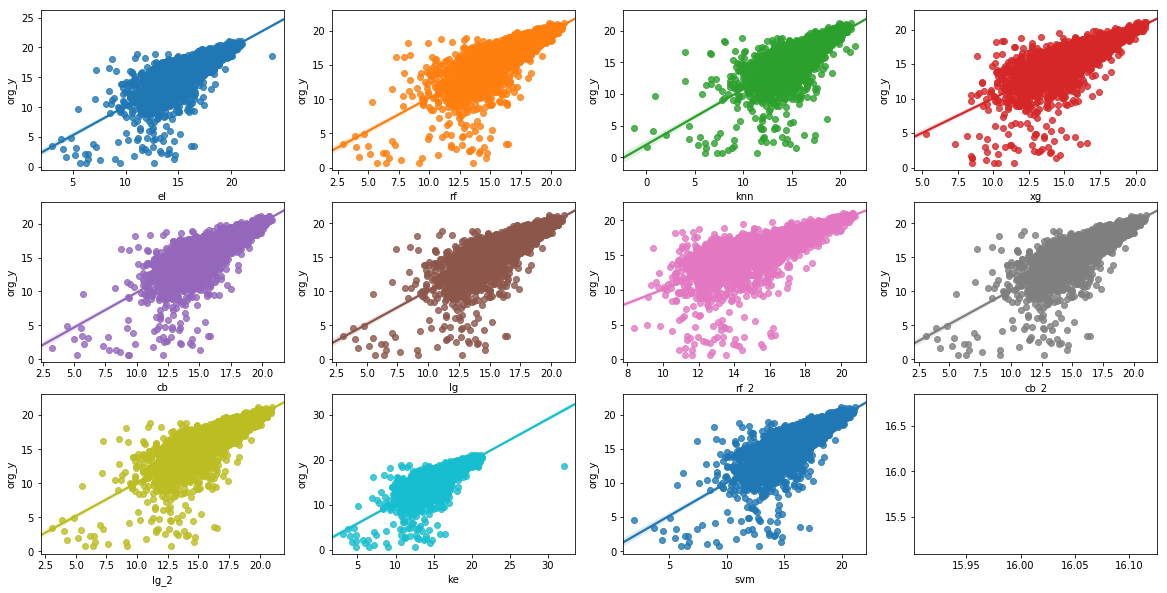

In [39]:
fig, axes = plt.subplots(3, 4, figsize = (20, 10))

for i, col in enumerate(cols):
  sns.regplot(x = col, y = 'org_y', data = meta_tr, ax = axes[i//4, i % 4])

In [0]:
# Save the files 
#meta_tr.to_csv('meta_tr_2.csv', index = False)
#meta_te.to_csv('meta_te_2.csv', index = False)

In [173]:
meta_te.head()

,el,rf,knn,xg,cb,lg,rf_2,cb_2,lg_2,ke,pred0,svm
0,15.826039,15.927878,22.470970,16.487000,15.528364,15.819544,14.745739,15.839397,15.861738,15.999568,15.839397,17.516052
1,13.203368,12.973130,13.483617,13.481292,14.179688,12.932788,13.748202,12.996774,13.016217,13.351679,12.996774,13.152432
2,16.073559,16.084702,17.267429,16.183146,15.570000,16.084248,15.907350,16.048818,16.069790,16.174849,16.048818,16.875621
3,15.990255,15.995742,15.931122,16.051851,16.293909,15.987957,15.697832,15.969868,15.990840,16.126808,15.969868,16.125525
4,13.576774,13.588546,13.931299,13.645041,13.629000,13.619250,13.410052,13.558164,13.579427,13.723704,13.558164,13.713821


In [177]:
cols = ['lg_2', 'el', 'knn']

sub = meta_tr[cols]
sub = np.array(sub)

pred = np.mean(sub, axis= 1)
#pred.shape
get_loss(pred, meta_tr.org_y)

1.8788154050514478

In [0]:
sub = meta_te[cols]
sub = np.array(sub)

final = np.mean(sub, axis= 1)

In [0]:
final = (meta_te.lg_2 + meta_te.el + meta_te.knn)/3

## 2nd Layer Modeling

In [0]:
cols = ['lr', 'el', 'rd', 'knn', 'rf', 'rf2', 'ad']

nrow = X.shape[0]
ncol = len(cols)
dims = np.zeros((nrow, ncol))

meta_tr = pd.DataFrame(dims, columns = cols)
meta_tr['val'] = 0

# Create meta-test set
nrow = te.shape[0]
dims = np.zeros((nrow, ncol))
meta_te = pd.DataFrame(dims, columns = cols)

# Cross Validation
k = 5
seed = 30
cv = KFold(n_splits = k, shuffle = True, random_state = seed)

In [0]:
    scores = np.zeros(k)
    for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
        X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
        X_val, y_val = X.iloc[val_idx, :], y[val_idx]

        model.fit(X_tr, y_tr)
        pred_val = model.predict(X_val)
        scores[i] = get_loss(pred_val, y_val)
        print("========={}-th Fold Score: {}".format(i, scores[i]))
        
        meta_tr[col][val_idx] = pred_val
        meta_tr['val'][val_idx] = y_val

    print("=========Total Score: ", np.mean(scores))
    model.fit(X, y)
    meta_te[col] = model.predict(te)

### Linear Regression

In [0]:
model_lr = LinearRegression(normalize=True)
kfold_validate(X, y, te, model_lr, 'lr')     # 1.8395  -> 1.8125

=========0-th Fold Score: 1.893159370376598
=========1-th Fold Score: 1.8496660179765172
=========2-th Fold Score: 1.8956892685722058
=========3-th Fold Score: 1.7802761298361787
=========4-th Fold Score: 1.643811468200954
=========Total Score:  1.8125204509924906


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### Elastic Net

In [0]:
model_el = ElasticNet(alpha = .01, l1_ratio = 0, max_iter = 1000)
kfold_validate(X_tr, y, te, model_el, 'el')

=========0-th Fold Score: 1.917413070244739
=========1-th Fold Score: 1.8688636589313894
=========2-th Fold Score: 1.7195309206529477
=========3-th Fold Score: 1.808851283161847
=========4-th Fold Score: 1.6475803798429176
=========Total Score:  1.7924478625667681


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3760.5669318612127, tolerance: 2.1667939388572846
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3803.621223577476, tolerance: 2.158456468524547
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3980.892891023189, tolerance: 2.2502944354982315
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3875.39294802

### Ridge Regression

In [0]:
model_rd = Ridge(alpha = .001, normalize = True)
kfold_validate(X_tr, y, te, model_rd, 'rd') 

=========0-th Fold Score: 1.909932760858079
=========1-th Fold Score: 1.8642653269617167
=========2-th Fold Score: 1.7198119655770567
=========3-th Fold Score: 1.8016343350294832
=========4-th Fold Score: 1.647363542694535
=========Total Score:  1.7886015862241742


### KNN

In [0]:
model_knn = KNeighborsRegressor(n_neighbors = 40, weights = 'distance', p = 2)
kfold_validate(X_tr, y, te, model_knn, 'knn')

=========0-th Fold Score: 2.0355561037024588
=========1-th Fold Score: 1.9365899471395904
=========2-th Fold Score: 1.746906677372933
=========3-th Fold Score: 1.885838829679332
=========4-th Fold Score: 1.6577754161940823
=========Total Score:  1.8525333948176794


### Random Forest

In [0]:
model_rf = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
kfold_validate(X_tr, y, te, model_rf, 'rf')

=========0-th Fold Score: 1.9996883631615952
=========1-th Fold Score: 1.9237714108777915
=========2-th Fold Score: 1.7770463935853216
=========3-th Fold Score: 1.8943301674916382
=========4-th Fold Score: 1.6883724570383318
=========Total Score:  1.8566417584309356


In [0]:
model_rf = RandomForestRegressor(n_estimators = 1000, max_depth = 5)
kfold_validate(X_tr, y, te, model_rf, 'rf2') 

=========0-th Fold Score: 1.9817274223513066
=========1-th Fold Score: 1.9150382113481486
=========2-th Fold Score: 1.7996156026214456
=========3-th Fold Score: 1.8670691485207371
=========4-th Fold Score: 1.6802925499920314
=========Total Score:  1.848748586966734


### Adaboost

In [0]:
model_ad = AdaBoostRegressor(n_estimators = 1000, learning_rate = .05,  
                             loss = 'square', random_state = seed)
kfold_validate(X_tr, y, te, model_rf, 'ad')

=========0-th Fold Score: 1.9793951157837226
=========1-th Fold Score: 1.9137170607894907
=========2-th Fold Score: 1.7953522932973796
=========3-th Fold Score: 1.8694418461967053
=========4-th Fold Score: 1.6821350798167707
=========Total Score:  1.8480082791768138


### Xgboost

In [0]:
meta_tr['xg'] = 0
meta_te['xg'] = 0

model_xg = XGBRegressor(objective = 'reg:linear',
                            n_estimators = 3000,
                            max_depth = 7,
                            learning_rate = 0.1,
                            early_stopping_rounds = 100,
                            gamma = 1.0,
                            subsample = 0.7,
                            colsample_bytree = 0.7,
                            colsample_bylevel = 0.7,
                            silent = True)
kfold_validate(X, y, te, model_xg, 'xg')    # 1.8289

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========0-th Fold Score: 2.0588123674058503


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========1-th Fold Score: 2.0274496256058234


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========2-th Fold Score: 1.948256658558138


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========3-th Fold Score: 1.9348497746544275


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========4-th Fold Score: 1.911321468530414
=========Total Score:  1.9761379789509306


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Evaluation

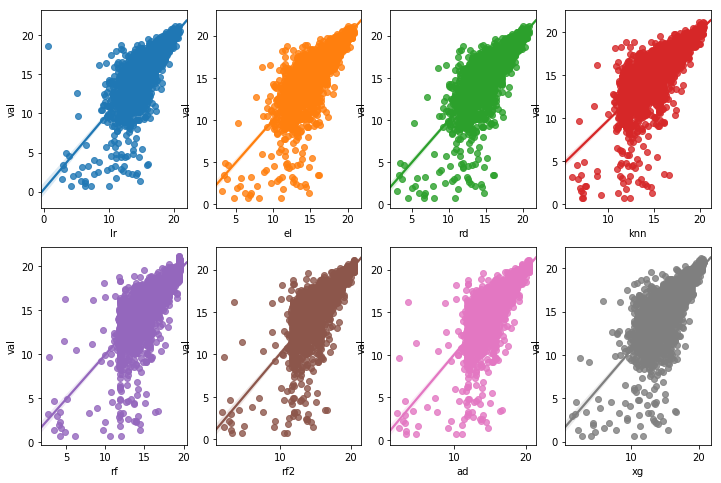

In [0]:
fig, axes = plt.subplots(2, 4, figsize = (12, 8))

  sns.regplot(x = col, y = 'val', data = meta_tr, ax = axes[i//4, i%4])

In [0]:
#final = (meta_te.lr + meta_te.el + meta_te.rf)/3


# Current Best score
final = (meta_te.lr + meta_te.el + meta_te.rd + meta_te.knn + meta_te.rf + meta_te.rf2 + meta_te.ad)/7
#final = (meta_te.lr + meta_te.el + meta_te.rd + meta_te.rf + meta_te.rf2 + meta_te.ad)/6

In [100]:
pred = (meta_tr.lr + meta_tr.el + meta_tr.rd + meta_tr.knn + meta_tr.rf + meta_tr.rf2 + meta_tr.ad)/7
get_loss(pred, meta_tr.val)

1.8050252549363297

In [101]:
pred = (meta_tr.lr + meta_tr.el + meta_tr.rd + meta_tr.knn + meta_tr.rf2 + meta_tr.ad)/6
get_loss(pred, meta_tr.val)

1.800175833161067

In [102]:
pred = (meta_tr.lr + meta_tr.el + meta_tr.rd + meta_tr.rf2 + meta_tr.ad)/5
get_loss(pred, meta_tr.val)

1.7974847520864066

In [103]:
pred = (meta_tr.lr + meta_tr.el + meta_tr.rd + meta_tr.ad)/4
get_loss(pred, meta_tr.val)

1.792856342452852

In [0]:
final = meta_te.rd

In [0]:
meta_tr.drop(['knn', 'rf', 'xg'], axis = 1, inplace = True)
meta_te.drop(['knn', 'rf', 'xg'], axis = 1, inplace = True)

## 3rd Layer Modeling

In [0]:
y = meta_tr.val
X_tr = meta_tr.drop('val', axis = 1)

te = meta_te

In [0]:
# Create meta-train set
cols = ['lr', 'rd', 'rf', 'rf2']

nrow = X.shape[0]
ncol = len(cols)
dims = np.zeros((nrow, ncol))

meta_tr = pd.DataFrame(dims, columns = cols)
meta_tr['val'] = 0

# Create meta-test set
nrow = te.shape[0]
dims = np.zeros((nrow, ncol))
meta_te = pd.DataFrame(dims, columns = cols)

# Cross Validation
k = 5
seed = 10
cv = KFold(n_splits = k, shuffle = True, random_state = seed)

In [119]:
model_lr = LinearRegression()
kfold_validate(X_tr, y, te, model_lr, 'lr')    # 1.8417   ->  1.8107

=========0-th Fold Score: 1.8255794907600436
=========1-th Fold Score: 1.6971655114483335
=========2-th Fold Score: 1.9071154185166823
=========3-th Fold Score: 1.8959454594963845
=========4-th Fold Score: 1.7279311626744165
=========Total Score:  1.8107474085791722


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [120]:
model_rd = Ridge(alpha = .01, normalize = True)
kfold_validate(X_tr, y, te, model_rd, 'rd')     # 1.8332   ->  1.8042

=========0-th Fold Score: 1.833097408817562
=========1-th Fold Score: 1.6817684251864964
=========2-th Fold Score: 1.8607513931554536
=========3-th Fold Score: 1.905252950030931
=========4-th Fold Score: 1.7405931194236128
=========Total Score:  1.804292659322811


In [121]:
model_rf = RandomForestRegressor(n_estimators = 3000, max_depth = 3)
kfold_validate(X_tr, y, te, model_rf, 'rf')     # 1.8279   ->  1.8190

=========0-th Fold Score: 1.8508995889323274
=========1-th Fold Score: 1.7389714010109418
=========2-th Fold Score: 1.815632812929424
=========3-th Fold Score: 1.9160949117394628
=========4-th Fold Score: 1.773630321446098
=========Total Score:  1.8190458072116507


In [122]:
model_rf = RandomForestRegressor(n_estimators = 2000, max_depth = 5)
kfold_validate(X_tr, y, te, model_rf, 'rf2')    # 1.8289   ->  1.9301

=========0-th Fold Score: 1.8348243434847231
=========1-th Fold Score: 1.7563920874906582
=========2-th Fold Score: 1.8668808350921695
=========3-th Fold Score: 1.9021005617104185
=========4-th Fold Score: 1.7904409918856368
=========Total Score:  1.8301277639327211


In [123]:
meta_tr.sample(10)

,lr,rd,rf,rf2,val
380,19.450947,19.407841,19.493367,19.302576,18.956460
1940,17.360992,17.340155,17.729958,17.478845,16.995562
475,12.378805,12.241025,12.203349,12.539220,14.293049
1178,15.353398,14.936013,14.801898,14.813818,16.213406
2863,15.945166,15.989812,15.809210,15.905215,15.947799
2117,3.719999,3.749542,3.356466,3.359072,1.609438
775,13.099912,13.009242,12.585907,12.785620,15.860920
2882,16.090042,15.908597,15.585080,15.775799,15.711537
2879,13.932575,13.810754,13.845087,13.240265,16.874218
874,17.811337,17.842674,18.002656,17.991227,18.802521


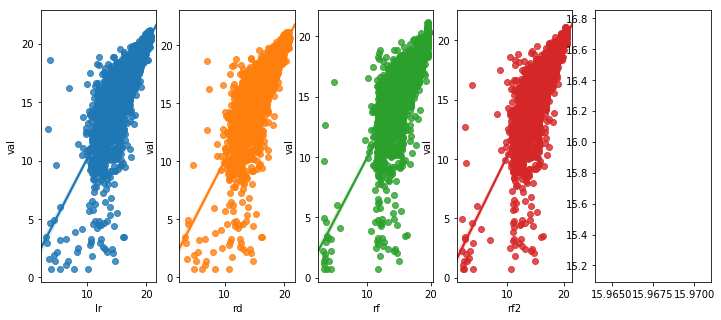

In [124]:
fig, axes = plt.subplots(1, 5, figsize = (12, 5))

for i, col in enumerate(meta_tr.columns[meta_tr.columns != 'val']):
  sns.regplot(x = col, y = 'val', data = meta_tr, ax = axes[i%5])

In [125]:
# Averaging the final result
#final = (meta_te.lr + meta_te.rd + meta_te.rf2)/3
#final = (meta_te.rf + meta_te.rf2)/2

pred = (meta_tr.rf + meta_tr.rd + meta_tr.lr)/3
get_loss(pred, meta_tr.val)

1.8026285107039033